# The Battle of Neighbourhoods

### Business Description

Everybody loves pizza! Even if you are on a strict diet you still have a crush on pizza, do not lie! <br />
It is almost a commodity, and thinking of so, we cannot have the chance of pizza shortage. <br />
That is why every neighbourhood has its own pizza place. It makes money on cheap ingredients. And if you "gourmetize it", it can lead to a true unique business. <br />
Thinking of that, if some customer wants to open their own pizza place or expand business, what would be the best place to run, considering population density (the more pizza lovers the better), neighbourhood popularity on that kind of food, nearby similar places and other considerations that may impact the business?

We will look upon the city of São Paulo. The city itself has 12M, summing um to its metropolitan area we reach the number of 21M people, making it the world's 4th largest metropolitan city in population. From the government open data, we can get information on estimated population per neighbourhood, total area (se we can estimate populational density), and from foursquare, we can get the venues localized in a certain region. We will start in the Neighbourhood of Bixiga, where it is knows for being traditionally a place where italians immigrants arrivd first, and so, have the best italians restaurants.

### Data Description

Most of the data we will get from the city hall open data website: http://dados.prefeitura.sp.gov.br/ <br />
We will use also the table in this website for getting the area of each district: https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php?p=12758 <br />

Everry other data used for enrichment of the location we will take from Fourquare API

### Import Libraries

In [1]:
import os
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import requests
import geocoder
import json
from unidecode import unidecode
from pykml import parser
import geopandas as gp
from bs4 import BeautifulSoup
import folium
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

### Download and create pandas Dataframe for São Paulo Areas

In [2]:
url = 'https://www.prefeitura.sp.gov.br/cidade/secretarias/subprefeituras/subprefeituras/dados_demograficos/index.php?p=12758'

In [3]:
req = requests.get(url)
if req.status_code == 200:
    print('Requisition OK')
    content = req.content

Requisition OK


In [4]:
soup = BeautifulSoup(content, 'html.parser')

In [5]:
table = soup.find(name='table')

In [6]:
table_str = str(table)
df_area = pd.read_html(table_str)[0]

In [7]:
print(df_area.shape)
print(df_area.columns)

(126, 5)
Index(['Subprefeituras', 'Distritos', 'Área (km²)', 'População (2010)',
       'Densidade Demográfica (Hab/km²)'],
      dtype='object')


In [8]:
df_area.head()

Subprefeituras     Distritos  Área (km²)  População (2010)  \
0     Aricanduva    Aricanduva       660.0            89.622   
1     Aricanduva        Carrão       750.0            83.281   
2     Aricanduva  Vila Formosa       740.0            94.799   
3     Aricanduva         TOTAL      2150.0           267.702   
4        Butantã       Butantã      1250.0            54.196   

   Densidade Demográfica (Hab/km²)  
0                           13.579  
1                           11.104  
2                           12.811  
3                           12.451  
4                            4.336

### Download and create pandas Dataframe for São Paulo Population

In [9]:
df_pop = pd.read_excel('C:\Courses\Coursera\IBM Data Science\Capstone Project\populacao_censitaria_e_projecoes_populac_2008.xls',header=4)

In [10]:
df_pop.head()

Distritos          2008          2009     2010          2011  \
0  Bela Vista  68237.022281  68850.860070  69460.0  69867.581691   
1  Bom Retiro  32325.862936  33102.104796  33892.0  34598.264094   
2     Cambuci  35172.491571  36051.968372  36948.0  37754.472929   
3  Consolação  56850.531154  57111.387208  57365.0  57449.573638   
4   Liberdade  67662.466721  68378.527185  69092.0  69606.742467   

           2012          2013          2014          2015          2016  \
0  70269.354572  70665.066271  71054.458089  71437.264900  71813.215055   
1  35315.124511  36042.568048  36780.571012  37529.098609  38288.104325   
2  38574.047341  39406.744630  40252.574716  41111.535332  41983.611275   
3  57527.558490  57598.825566  57663.243698  57720.679540  57770.997570   
4  70117.137138  70622.907724  71123.769933  71619.431319  72109.591126   

           2017          2018          2019          2020          2025  \
0  72182.030296  72543.425681  72897.109512  73242.783282  74840.072361   
1  39057.529275  39837.301537  40627.335464  41427.530971  45576.325293   
2  42868.773638  43766.979007  44678.168634  45602.267584  50412.533018   
3  57814.060095  57849.727271  57877.857129  57898.305606  57880.145141   
4  72593.940144  73072.160572  73543.925890  74008.900738  76219.549463   

           2030          2040  
0  76188.385780  77954.762919  
1  49954.518334  59250.286019  
2  55523.369573  66495.941664  
3  57647.248447  56457.450398  
4  78204.909024  81285.676939

### Download and create pandas Dataframe from Foursquare API

In [11]:
client_id = 'O03S2MHOGAY4WGMUBIVP0RRXRJYLY4FTX5O5YI3D0OSPXBQU'
client_secret = 'SAO0I02RQETGEQHGTCGMAGF1OF3ZDF1LBBNVDRP1ZBKP50CG'

In [12]:
lat = '-23.557213'
lng = '-46.64654'
limit = '500'
query = 'pizza'
version = '20200331'

api_url = 'https://api.foursquare.com/v2/venues/search?ll='+ lat+','+lng+'&limit='+limit+'&query='+query+'&client_id='+client_id+'&client_secret='+client_secret+'&v='+version

In [13]:
api_get = requests.get(api_url)
if api_get.status_code == 200:
    print('Requisition OK')
    api_content = api_get.content

Requisition OK


In [14]:
venues = json.loads(api_content)['response']['venues']

In [15]:
venues[0]

{'id': '5c2643a7492822002db4b0c5',
 'name': 'Coração Bixiga (Pizza na Pedra)',
 'location': {'address': 'rua: conselheiro carrão,475, Bela Vista, treze de maio',
  'crossStreet': 'Igreja Achiropita',
  'lat': -23.557921128881173,
  'lng': -46.6468458250165,
  'labeledLatLngs': [{'label': 'display',
    'lat': -23.557921128881173,
    'lng': -46.6468458250165}],
  'distance': 84,
  'postalCode': '01328-000',
  'cc': 'BR',
  'neighborhood': 'Bixiga',
  'city': 'São Paulo',
  'state': 'SP',
  'country': 'Brasil',
  'formattedAddress': ['rua: conselheiro carrão,475, Bela Vista, treze de maio (Igreja Achiropita)',
   'São Paulo, SP',
   '01328-000',
   'Brasil']},
 'categories': [{'id': '4bf58dd8d48988d1ca941735',
   'name': 'Pizza Place',
   'pluralName': 'Pizza Places',
   'shortName': 'Pizza',
   'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/pizza_',
    'suffix': '.png'},
   'primary': True}],
 'venuePage': {'id': '519337417'},
 'referralId': 'v-1586182310',
 'hasPerk'

In [16]:
df_venues = json_normalize(venues)

c:\users\victor\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.


In [17]:
df_venues.head()

id                             name  \
0  5c2643a7492822002db4b0c5  Coração Bixiga (Pizza na Pedra)   
1  4dcf4198e4cd130e167d2f67                  Pizzaria Falobo   
2  4cc9580ebcb1b1f711670e8a                  Super Pizza Pan   
3  4b7f4874f964a520c32430e3                   Domino's Pizza   
4  50c7582fe4b072dfb88708e1                Pizza Hut Express   

                                          categories    referralId  hasPerk  \
0  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...  v-1586182310    False   
1  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...  v-1586182310    False   
2  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...  v-1586182310    False   
3  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...  v-1586182310    False   
4  [{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...  v-1586182310    False   

                                    location.address location.crossStreet  \
0  rua: conselheiro carrão,475, Bela Vista, treze...    Igreja Achiropita   
1                            Av. Nove de Julho, 1384                  NaN   
2                             R. Treze de Maio, 1452    R. Carlos Sampaio   
3                                    Al. Santos, 996                  NaN   
4                                  Shopping Center 3                  NaN   

   location.lat  location.lng  \
0    -23.557921    -46.646846   
1    -23.556676    -46.649862   
2    -23.566089    -46.644848   
3    -23.566366    -46.652677   
4    -23.557824    -46.659097   

                             location.labeledLatLngs  location.distance  \
0  [{'label': 'display', 'lat': -23.5579211288811...                 84   
1  [{'label': 'display', 'lat': -23.5566763091519...                344   
2  [{'label': 'display', 'lat': -23.5660888299832...               1003   
3  [{'label': 'display', 'lat': -23.5663655466980...               1195   
4  [{'label': 'display', 'lat': -23.5578238878550...               1283   

  location.postalCode location.cc location.neighborhood location.city  \
0           01328-000          BR                Bixiga     São Paulo   
1           01312-001          BR                   NaN     São Paulo   
2           01327-002          BR                   NaN     São Paulo   
3           01418-903          BR                   NaN     São Paulo   
4           01310-200          BR                   NaN     São Paulo   

  location.state location.country  \
0             SP           Brasil   
1             SP           Brasil   
2             SP           Brasil   
3             SP           Brasil   
4             SP           Brasil   

                           location.formattedAddress venuePage.id  
0  [rua: conselheiro carrão,475, Bela Vista, trez...    519337417  
1  [Av. Nove de Julho, 1384, São Paulo, SP, 01312...          NaN  
2  [R. Treze de Maio, 1452 (R. Carlos Sampaio), S...          NaN  
3  [Al. Santos, 996, São Paulo, SP, 01418-903, Br...          NaN  
4  [Shopping Center 3, São Paulo, SP, 01310-200, ...          NaN

### Clean up and organize the Dataframes

##### df_area -> get only the area feature. Population and demographic density will be discarded
##### df_pop  -> get only the 2020 column, for estimated (and actual) population
##### df_venues -> get id, name, lat, lng and neighbourhood data

In [18]:
df_area = df_area[['Subprefeituras','Distritos','Área (km²)']].dropna()
df_area = df_area[~df_area['Distritos'].str.contains('TOTAL')]
print(df_area.shape)
df_area.head()

(96, 3)


Subprefeituras     Distritos  Área (km²)
0     Aricanduva    Aricanduva       660.0
1     Aricanduva        Carrão       750.0
2     Aricanduva  Vila Formosa       740.0
4        Butantã       Butantã      1250.0
5        Butantã       Morumbi      1140.0

In [19]:
df_pop = df_pop[['Distritos',2020]].dropna()
print(df_pop.shape)
df_pop.head()

(96, 2)


Distritos          2020
0  Bela Vista  73242.783282
1  Bom Retiro  41427.530971
2     Cambuci  45602.267584
3  Consolação  57898.305606
4   Liberdade  74008.900738

In [20]:
df_venues = df_venues[['id','name','location.lat','location.lng','location.neighborhood']].rename(columns={'location.lat':'lat','location.lng':'lng','location.neighborhood':'neighborhood'})

In [21]:
df_venues.head()

id                             name        lat  \
0  5c2643a7492822002db4b0c5  Coração Bixiga (Pizza na Pedra) -23.557921   
1  4dcf4198e4cd130e167d2f67                  Pizzaria Falobo -23.556676   
2  4cc9580ebcb1b1f711670e8a                  Super Pizza Pan -23.566089   
3  4b7f4874f964a520c32430e3                   Domino's Pizza -23.566366   
4  50c7582fe4b072dfb88708e1                Pizza Hut Express -23.557824   

         lng neighborhood  
0 -46.646846       Bixiga  
1 -46.649862          NaN  
2 -46.644848          NaN  
3 -46.652677          NaN  
4 -46.659097          NaN

### Adding additional data about the venues

In [22]:
df_venues['price'] = np.nan

In [ ]:
for i,venue in enumerate(df_venues.id):
    venue_id=str(venue)
    venue_detail = 'https://api.foursquare.com/v2/venues/'+venue_id+'?&client_id='+client_id+'&client_secret='+client_secret+'&v='+version
    api_get = requests.get(venue_detail)
    if api_get.status_code == 200:
        api_content = api_get.content
    detail = json.loads(api_content)['response']['venue']
    df_venues['price'][i] = detail['price']['tier']

In [25]:
df_venues = gp.GeoDataFrame(
    df_venues, geometry=gp.points_from_xy(df_venues.lng, df_venues.lat))
df_venues.crs = 'EPSG:4326'

In [26]:
df_venues.head()

id                             name        lat  \
0  5c2643a7492822002db4b0c5  Coração Bixiga (Pizza na Pedra) -23.557921   
1  4dcf4198e4cd130e167d2f67                  Pizzaria Falobo -23.556676   
2  4cc9580ebcb1b1f711670e8a                  Super Pizza Pan -23.566089   
3  50c7582fe4b072dfb88708e1                Pizza Hut Express -23.557824   
4  4b7f4874f964a520c32430e3                   Domino's Pizza -23.566366   

         lng neighborhood  price                     geometry  
0 -46.646846       Bixiga    1.0  POINT (-46.64685 -23.55792)  
1 -46.649862          NaN    1.0  POINT (-46.64986 -23.55668)  
2 -46.644848          NaN    3.0  POINT (-46.64485 -23.56609)  
3 -46.659097          NaN    3.0  POINT (-46.65910 -23.55782)  
4 -46.652677          NaN    2.0  POINT (-46.65268 -23.56637)

### Data Exploration

In [27]:
df_venues.isnull().sum()

id               0
name             0
lat              0
lng              0
neighborhood    43
price            0
geometry         0
dtype: int64

In [28]:
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'r'

filename = 'C:/Courses/Coursera/IBM Data Science/Capstone Project/LAYER_DISTRITO/Distritos SP.kml'
shape = gp.read_file(filename, driver = 'KML')

As we are missing most neighbourhood data from the api, we will import a shapefile and include the data using geospatial funcions from http://dados.prefeitura.sp.gov.br/dataset/distritos

In [29]:
shape.head()

Name Description  \
0  JOSE BONIFACIO         JBO   
1     JD SAO LUIS         JDS   
2     ARTUR ALVIM         AAL   
3         JAGUARA         JAG   
4   VILA PRUDENTE         VPR   

                                            geometry  
0  POLYGON ((-46.44578 -23.55602, -46.44564 -23.5...  
1  POLYGON ((-46.75793 -23.64810, -46.75790 -23.6...  
2  POLYGON ((-46.47456 -23.52332, -46.47456 -23.5...  
3  POLYGON ((-46.75555 -23.49467, -46.75554 -23.4...  
4  POLYGON ((-46.58102 -23.57250, -46.58099 -23.5...

In [30]:
latitude = df_venues.lat.mean()
longitude = df_venues.lng.mean()

_map = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.GeoJson(shape).add_to(_map)
for lat, lon in zip(df_venues['lat'],df_venues['lng']):
    folium.CircleMarker([lat,lon],color='red', radius =3).add_to(_map)
_map

### Joining all data

In [84]:
gdf = gp.sjoin(df_venues,shape, op='intersects',how="left")
gdf = gdf[['name','lat','lng','price','geometry','Name']]
gdf.head()

name        lat        lng  price  \
0  Coração Bixiga (Pizza na Pedra) -23.557921 -46.646846    1.0   
1                  Pizzaria Falobo -23.556676 -46.649862    1.0   
2                  Super Pizza Pan -23.566089 -46.644848    3.0   
3                Pizza Hut Express -23.557824 -46.659097    3.0   
4                   Domino's Pizza -23.566366 -46.652677    2.0   

                      geometry         Name  
0  POINT (-46.64685 -23.55792)   BELA VISTA  
1  POINT (-46.64986 -23.55668)   BELA VISTA  
2  POINT (-46.64485 -23.56609)   BELA VISTA  
3  POINT (-46.65910 -23.55782)   CONSOLACAO  
4  POINT (-46.65268 -23.56637)  JD PAULISTA

In [52]:
df_pop['Distritos'] = df_pop['Distritos'].apply(lambda x: unidecode(x).upper())
df_area['Distritos'] = df_area['Distritos'].apply(lambda x: unidecode(x).upper())

In [69]:
df_area.shape

(96, 3)

In [70]:
df_area=df_area.merge(df_pop,how='left', on = 'Distritos')

In [93]:
df = df_area.merge(gdf,left_on='Distritos', right_on='Name')

In [94]:
df['PopDensity'] = df[2020]/df['Área (km²)']
df = df.drop(['Name','Área (km²)',2020], axis=1)

In [95]:
df.head()

Subprefeituras     Distritos                     name        lat        lng  \
0     Casa Verde  CACHOEIRINHA            Patroni Pizza -23.471744 -46.650580   
1     Casa Verde         LIMAO                Pizza Hut -23.513111 -46.672501   
2       Ipiranga      IPIRANGA  Domino’s Pizza Ipiranga -23.595776 -46.606183   
3           Lapa   BARRA FUNDA     Golden Grill & Pizza -23.510204 -46.688515   
4           Lapa   BARRA FUNDA                Pizza Hut -23.526550 -46.674205   

   price                     geometry  PopDensity  
0    1.0  POINT (-46.65058 -23.47174)  100.624676  
1    3.0  POINT (-46.67250 -23.51311)  119.457584  
2    1.0  POINT (-46.60618 -23.59578)  105.533789  
3    3.0  POINT (-46.68851 -23.51020)   27.332669  
4    2.0  POINT (-46.67420 -23.52655)   27.332669

### Visualize the Data

In [97]:
latitude = df['lat'].mean()
longitude = df['lng'].mean()

In [100]:
_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, name, borough, neighborhood in zip(df['lat'], df['lng'], df['name'], df['Subprefeituras'], df['Distritos']):
    label = '{} - {}, {}'.format(name,neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(_map)  
_map

### Clustering data by location

#### Define number of clusters

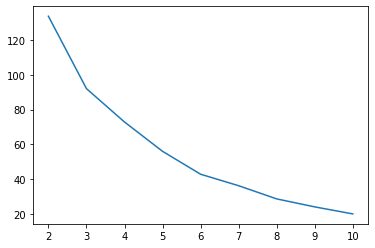

In [105]:
df_cluster = df[['lat','lng','price','PopDensity']]

df_cluster = StandardScaler().fit(df_cluster).transform(df_cluster)

inertia_list=[]

for k in range(2,11,1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(df_cluster)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(range(2,11,1),inertia_list)

#### Using k=3

In [106]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(df_cluster)
df.insert(0, 'Cluster Labels', kmeans.labels_)

In [118]:
df.groupby('Cluster Labels').mean()

lat        lng     price    PopDensity
Cluster Labels                                              
0              -23.540754 -46.648827  2.470588    151.457188
1              -23.572418 -46.649925  1.178571    189.891228
2              -23.536878 -46.685745  1.000000  18968.278833

In [119]:
_map = folium.Map(location=[latitude, longitude], zoom_start=10,tiles='Stamen Terrain')

kclusters=3

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for lat, lng, name, borough ,neighborhood,cluster in zip(df['lat'], df['lng'],df['name'], df['Subprefeituras'], df['Distritos'], df['Cluster Labels']):
    label = '{} - {}, {}'.format(name,neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(_map)  
_map

#### First Cluster - Red (High price, Low Pop Density, Center/Northern São Paulo)

In [125]:
df.loc[df['Cluster Labels'] == 0, df.columns[[1] + list(range(2, df.shape[1]))]]

Subprefeituras       Distritos                      name  \
0                  Casa Verde    CACHOEIRINHA             Patroni Pizza   
1                  Casa Verde           LIMAO                 Pizza Hut   
3                        Lapa     BARRA FUNDA      Golden Grill & Pizza   
4                        Lapa     BARRA FUNDA                 Pizza Hut   
7                       Mooca           MOOCA                 Pizza Hut   
8                       Mooca            PARI                 Pizza Hut   
10                  Pinheiros       PINHEIROS                 Pizza Hut   
19                         Sé      BELA VISTA           Super Pizza Pan   
22                         Sé      BELA VISTA                pizza rock   
28                         Sé      CONSOLACAO         Pizza Hut Express   
29                         Sé      CONSOLACAO         O Pedaço da Pizza   
30                         Sé      CONSOLACAO         Pizza Hut Express   
31                         Sé      CONSOLACAO             Bráz Pizzaria   
33                         Sé       LIBERDADE       Mr. Texas Pizza Pan   
34                         Sé       REPUBLICA                 Pizza Hut   
37                         Sé       REPUBLICA  O Melhor Pedaço da Pizza   
40  Vila Maria/Vila Guilherme  VILA GUILHERME                 Pizza Hut   

          lat        lng  price                     geometry  PopDensity  
0  -23.471744 -46.650580    1.0  POINT (-46.65058 -23.47174)  100.624676  
1  -23.513111 -46.672501    3.0  POINT (-46.67250 -23.51311)  119.457584  
3  -23.510204 -46.688515    3.0  POINT (-46.68851 -23.51020)   27.332669  
4  -23.526550 -46.674205    2.0  POINT (-46.67420 -23.52655)   27.332669  
7  -23.580336 -46.594480    3.0  POINT (-46.59448 -23.58034)  112.889496  
8  -23.521770 -46.624299    2.0  POINT (-46.62430 -23.52177)   66.776281  
10 -23.564225 -46.679470    3.0  POINT (-46.67947 -23.56422)   81.322557  
19 -23.566089 -46.644848    3.0  POINT (-46.64485 -23.56609)  281.703013  
22 -23.554663 -46.646772    2.0  POINT (-46.64677 -23.55466)  281.703013  
28 -23.557824 -46.659097    3.0  POINT (-46.65910 -23.55782)  156.481907  
29 -23.556397 -46.658346    2.0  POINT (-46.65835 -23.55640)  156.481907  
30 -23.542328 -46.657442    3.0  POINT (-46.65744 -23.54233)  156.481907  
31 -23.547989 -46.657645    3.0  POINT (-46.65764 -23.54799)  156.481907  
33 -23.571878 -46.627009    3.0  POINT (-46.62701 -23.57188)  200.024056  
34 -23.546713 -46.638505    2.0  POINT (-46.63851 -23.54671)  283.787787  
37 -23.544643 -46.639143    2.0  POINT (-46.63914 -23.54464)  283.787787  
40 -23.516349 -46.617194    2.0  POINT (-46.61719 -23.51635)   82.102983

#### Second Cluster - Purple (Low price, Medium Pop Density, Southern São Paulo)

In [126]:
df.loc[df['Cluster Labels'] == 1, df.columns[[1] + list(range(2, df.shape[1]))]]

Subprefeituras     Distritos                                      name  \
2        Ipiranga      IPIRANGA                   Domino’s Pizza Ipiranga   
9       Pinheiros    ITAIM BIBI                  La Pizza (Rossopomodoro)   
11      Pinheiros     PINHEIROS                       Pizza d'A Queijaria   
12      Pinheiros     PINHEIROS  Pizza Gradi 430 Napoletana Vila Madalena   
13      Pinheiros     PINHEIROS                                Pizza Crek   
14      Pinheiros     PINHEIROS                                 Pizza Hut   
15    Santo Amaro    CAMPO BELO                                 Pizza Hut   
16    Santo Amaro    CAMPO BELO                                 Pizza Hut   
17             Sé    BELA VISTA           Coração Bixiga (Pizza na Pedra)   
18             Sé    BELA VISTA                           Pizzaria Falobo   
20             Sé    BELA VISTA                                 Pizza Hut   
21             Sé    BELA VISTA                                     Pizza   
23             Sé    BELA VISTA                          Recanto Da Pizza   
24             Sé    BELA VISTA                            Kiosque Pizzas   
25             Sé    BELA VISTA                       Edy Pizza Artesanal   
26             Sé    BELA VISTA                  Pizza Prime - Bela Vista   
27             Sé    BELA VISTA                           La Nostra Pizza   
32             Sé     LIBERDADE                               Tutti Pizza   
35             Sé     REPUBLICA                          Vitrine da Pizza   
36             Sé     REPUBLICA                              Studio Pizza   
38             Sé     REPUBLICA                              Arte e Pizza   
39             Sé            SE                    Sala Vip Pizza & Pasta   
41   Vila Mariana         SAUDE                            Domino's Pizza   
42   Vila Mariana         SAUDE                                 Pizza Hut   
43   Vila Mariana         SAUDE                           Pizza de Circus   
44   Vila Mariana  VILA MARIANA                         Ziovito Pizza Bar   
45   Vila Mariana  VILA MARIANA                   Pizza Crek Vila Mariana   
46   Vila Mariana  VILA MARIANA       Dídio Pizza Delivery - Vila Mariana   

          lat        lng  price                     geometry  PopDensity  
2  -23.595776 -46.606183    1.0  POINT (-46.60618 -23.59578)  105.533789  
9  -23.591257 -46.683409    1.0  POINT (-46.68341 -23.59126)  101.935602  
11 -23.555672 -46.686160    1.0  POINT (-46.68616 -23.55567)   81.322557  
12 -23.551144 -46.690760    1.0  POINT (-46.69076 -23.55114)   81.322557  
13 -23.558906 -46.690755    1.0  POINT (-46.69075 -23.55891)   81.322557  
14 -23.572881 -46.695663    2.0  POINT (-46.69566 -23.57288)   81.322557  
15 -23.626631 -46.659494    1.0  POINT (-46.65949 -23.62663)   70.713903  
16 -23.615159 -46.667421    2.0  POINT (-46.66742 -23.61516)   70.713903  
17 -23.557921 -46.646846    1.0  POINT (-46.64685 -23.55792)  281.703013  
18 -23.556676 -46.649862    1.0  POINT (-46.64986 -23.55668)  281.703013  
20 -23.570732 -46.643692    2.0  POINT (-46.64369 -23.57073)  281.703013  
21 -23.555597 -46.652551    1.0  POINT (-46.65255 -23.55560)  281.703013  
23 -23.559152 -46.649591    1.0  POINT (-46.64959 -23.55915)  281.703013  
24 -23.556061 -46.639645    1.0  POINT (-46.63965 -23.55606)  281.703013  
25 -23.557415 -46.642056    1.0  POINT (-46.64206 -23.55741)  281.703013  
26 -23.564327 -46.648907    1.0  POINT (-46.64891 -23.56433)  281.703013  
27 -23.560439 -46.641857    1.0  POINT (-46.64186 -23.56044)  281.703013  
32 -23.567829 -46.636263    1.0  POINT (-46.63626 -23.56783)  200.024056  
35 -23.545990 -46.640915    1.0  POINT (-46.64092 -23.54599)  283.787787  
36 -23.543652 -46.640050    1.0  POINT (-46.64005 -23.54365)  283.787787  
38 -23.549867 -46.645844    1.0  POINT (-46.64584 -23.54987)  283.787787  
39 -23.541664 -46.629297    1.0  POINT (-46.62930 -23.54166)  127.029129  
41 -23.615118 -46.626685    1.0  POINT (-46.

#### Third Cluster (Low price, Very High Pop Density, Western São Paulo)

In [127]:
df.loc[df['Cluster Labels'] == 2, df.columns[[1] + list(range(2, df.shape[1]))]]

Subprefeituras Distritos                    name        lat        lng  \
5           Lapa  PERDIZES  Pizza Pompeia delivery -23.540974 -46.680303   
6           Lapa  PERDIZES         Galpão da Pizza -23.532782 -46.691186   

   price                     geometry    PopDensity  
5    1.0  POINT (-46.68030 -23.54097)  18968.278833  
6    1.0  POINT (-46.69119 -23.53278)  18968.278833

### Results

We can finally conclude two things. Considering only population density, location and price of the nerby pizza places, if we have a low budget, it is possible to sacrifice quality for price or choose to make high quality pizzas for a reasonable value.

For the first, my recomendation would be in the western neighbourhoods of São Paulo, due to a lack of neaby competition, and the high population density, which can lead to more customers in a small radius.

The second choice would be open/expand your business in an area which is famous for its price and quality. Since there are a considerably high number of venues with similar characteristics, we can infer that there are customers that pay a high price for a product in some distance radius around these places. The choice for opening some high quality pizzerias would be then the Center/Northern districts of São Paulo.

Note: even though this study was made on real, reliable and actual data, there are many other variables to be considered. This is just a preliminary study of what can be done using free external data, and machine learning techniques combined for a better business understand.